In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
from Data.Data_Module import Data_Module
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
from Data.image_transforms import Image_Transforms
import cv2
import cv2
import PIL
import numpy as np
transform = transforms.ToPILImage()



dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [3]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module(stage = 'fit',
                 set_max_label_length = 128,
                 number_png_images_to_use_in_dataset=250*1000,
                 labels_transform='default',
                image_transform_name ='alb',
                 train_val_fraction = 0.999,
                   vocabulary_path = 'Tokenizer/230k_ver2.json',
                load_vocabulary = True,
                      image_padding = True,
                      max_width = 10*1000,


                 batch_size = 128,
                num_workers = 8,
                data_on_gpu = True,
                )

In [4]:
print( 
    'Vocabulary size:',len(dataset.vocabulary),
    '\nMax label length:', dataset.max_label_length,
    "\nStart <S> goes to index ",dataset.vocabulary['<S>'],
      "\nEnd <E> goes to index ",dataset.vocabulary['<E>'],
      "\nPadding <P> goes to index ",dataset.vocabulary['<P>'],
)

Vocabulary size: 581 
Max label length: 130 
Start <S> goes to index  0 
End <E> goes to index  1 
Padding <P> goes to index  2


In [5]:


# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s

In [6]:
model = ResNetTransformer(dataset=dataset).to(dev)
model.load_state_dict(torch.load(("Models_Parameters_Log/Ver3_128Height_256embed_resnet18_4layers_8ratio.pth"), map_location=torch.device('cpu')))
lit_model = LitResNetTransformer(model=model, WandB=False)
lit_model.eval()
lit_model.freeze()
scripted_save = lit_model.to_torchscript()
torch.jit.save(scripted_save, "Models_Parameters_Log/scripted_model1.pt")


/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torch/jit/_recursive.py:262: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


In [7]:
scripted = torch.jit.load("Models_Parameters_Log/scripted_model1.pt")

In [17]:
import albumentations
from albumentations.augmentations.geometric.resize import Resize
import torch.nn.functional as F

MAX_RATIO = 8
GOAL_HEIGHT = 128

def find_ratio(h, w, goal):
    return goal/h
    


def predict(image_path):
   
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    ratio =w / h
    if ratio == 0:
        ratio = 1 
    if ratio > MAX_RATIO:
        ratio = MAX_RATIO
        
    new_h = GOAL_HEIGHT
    new_w = int(new_h * ratio)
    image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    
    max_H = 128
    max_W = 1024

    image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)

    
    print(image_tensor.shape)
    print(display(transform(image_tensor)))
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))



def predict_inverted(image_path):
   
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    image = cv2.bitwise_not(image)
    ratio =w / h
    if ratio == 0:
        ratio = 1 
    if ratio > MAX_RATIO:
        ratio = MAX_RATIO
        
    new_h = GOAL_HEIGHT
    new_w = int(new_h * ratio)
    image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    
    max_H = 128
    max_W = 1024

    image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)

    
    print(image_tensor.shape)
    print(display(transform(image_tensor)))
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

    
    
    
def predict_simple(image_path):
   
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    #ratio =w / h
    #if ratio == 0:
        #ratio = 1 
    #if ratio > MAX_RATIO:
        #ratio = MAX_RATIO
        ##new_h = GOAL_HEIGHT
        #new_w = int(new_h * ratio)
        #image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image']#[:1]
    print(display(transform(image_tensor)))
    
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

    
    
    
    
    
def predict_scaled(image_path):
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    ascpect = w/h
    if ascpect == 0:
        ascpect = 1 
    if ascpect > MAX_RATIO:
        ascpect = MAX_RATIO
    
    downscale = GOAL_HEIGHT/h
    image = cv2.resize(image, (0,0), fx=downscale, fy=downscale,interpolation=cv2.INTER_LINEAR)
   
    print(image.shape)
    



    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    max_H = 128
    max_W = 1024

    if h<128 and w<1024:
        image_tensor = F.pad(image_tensor, (0, max_W - w, 0, max_H - h), value=0)

    print(display(transform(image_tensor)))
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

    
# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s
    

In [9]:
IMAGES= [#'Jupyter_Notebooks/test_photos/79a37d9d8b727e9.png',
         "Jupyter_Notebooks/test_photos/0a0df4c4229b725.png",
         "Jupyter_Notebooks/test_photos/zarhin.png",
         "Jupyter_Notebooks/test_photos/my_image.png",
         "Jupyter_Notebooks/test_photos/screenshot_1.png",
         "Jupyter_Notebooks/test_photos/screenshot_3.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_14.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_10.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_13.png",
          "Jupyter_Notebooks/test_photos/Screen Shot_11.png",
         "Jupyter_Notebooks/test_photos/screenshot_2.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_18.png",
        'Jupyter_Notebooks/test_photos/128.png',
         'Jupyter_Notebooks/test_photos/128_2.png',
         'Jupyter_Notebooks/test_photos/image_3.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_15.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_11.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_16.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_17.png',
         'Jupyter_Notebooks/test_photos/screenshot_2.png',
         'Jupyter_Notebooks/test_photos/ratio25.png',
         'Jupyter_Notebooks/test_photos/ratio31.png',
        'Jupyter_Notebooks/test_photos/ratio76.png',
         
    

]

(128, 555, 3)


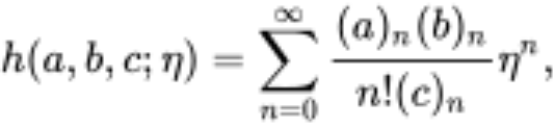

None
torch.Size([1, 128, 1024])


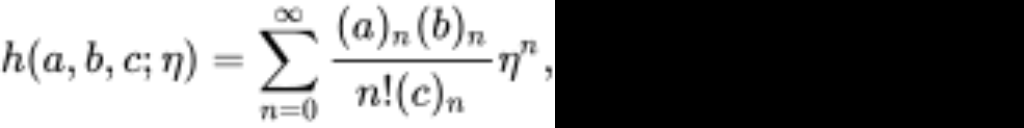

None

Predicted formula:
 <S> h \{ ( a , b , c ; \eta ) = \sum _ { r _ { 1 } = 0 } ^ { \infty } \frac { ( a ) _ { n } ( b ) _ { r _ { n } } } { n ! ( c ) _ { \mathrm { n } } } \eta ^ { r } , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 569, 3)


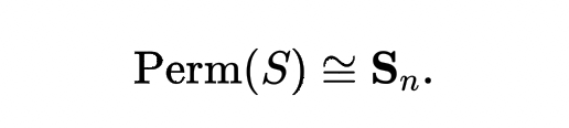

None
torch.Size([1, 128, 1024])


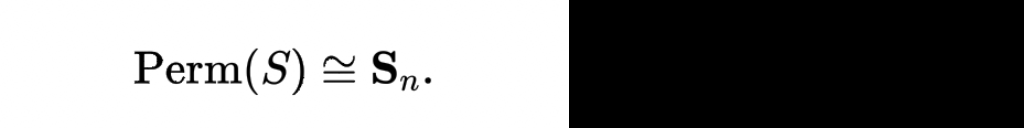

None

Predicted formula:
 <S> \mathrm { P e r m } ( S ) \cong { \bf S } _ { n } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 484, 3)


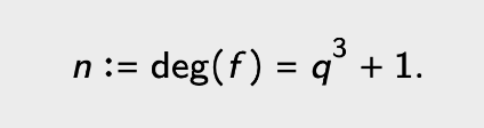

None
torch.Size([1, 128, 1024])


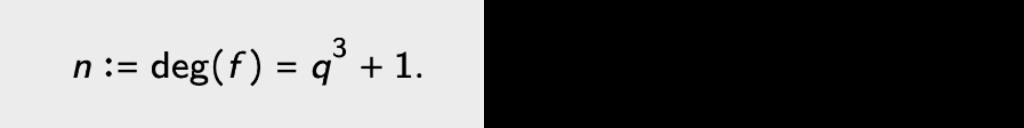

None

Predicted formula:
 <S> n : = \, \mathrm { d e g } ( \, f \, ) \, = \, { \bf q } ^ { 3 } + \, { \bf 1 } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 554, 3)


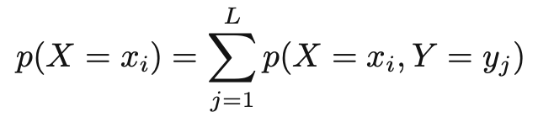

None
torch.Size([1, 128, 1024])


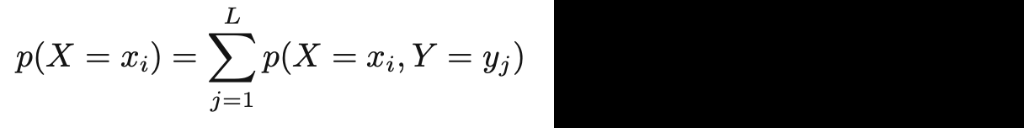

None

Predicted formula:
 <S> p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 432, 3)


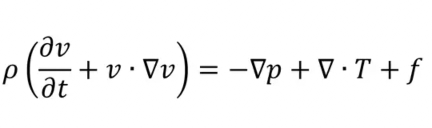

None
torch.Size([1, 128, 1024])


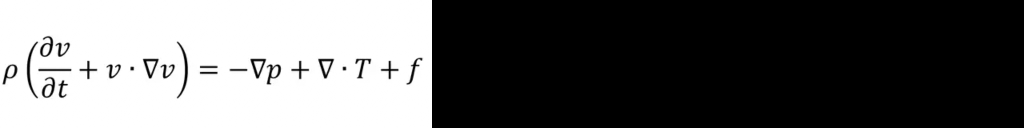

None

Predicted formula:
 <S> \rho \left( \frac { \partial v } { \partial t } + \nu \cdot \nabla \nu \right) = - \nabla p + \nabla \cdot T + f <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 911, 3)


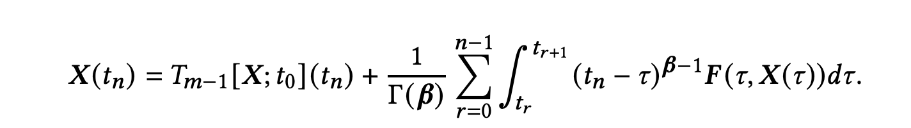

None
torch.Size([1, 128, 1024])


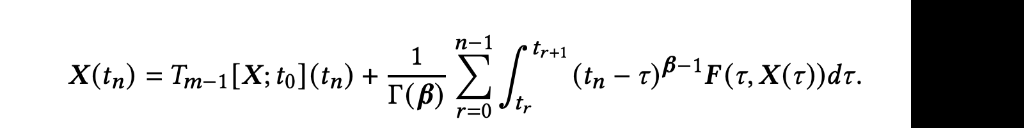

None

Predicted formula:
 <S> X ( t _ { n } ) = T _ { m - 1 } [ X ; t _ { 0 } ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \beta ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { t r } ^ { t _ { r + 1 } } ( t _ { n } - \tau ) ^ { \beta - 1 } F ( \tau , X ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 1024, 3)


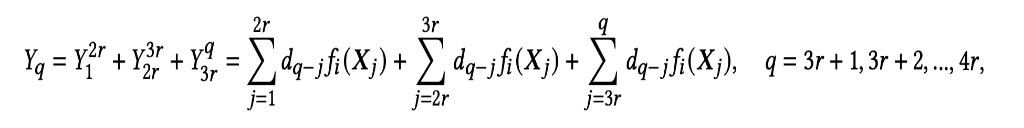

None
torch.Size([1, 128, 1024])


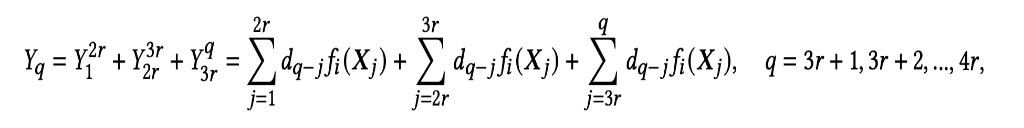

None

Predicted formula:
 <S> Y _ { q } = Y _ { 1 } ^ { 2 r } + Y _ { 2 r } ^ { 3 r } + Y _ { 3 r } ^ { q } = \sum _ { j = 1 } ^ { 2 r } d _ { q - j f _ { i } } ( X _ { j } ) + \sum _ { j = 2 r } ^ { 3 r } d _ { q - j f _ { i } ( X _ { j } ) + \sum _ { j = 3 r } ^ { q } d _ { q - j f _ { i } ( X


<IPython.core.display.Math object>

None
(128, 1024, 3)


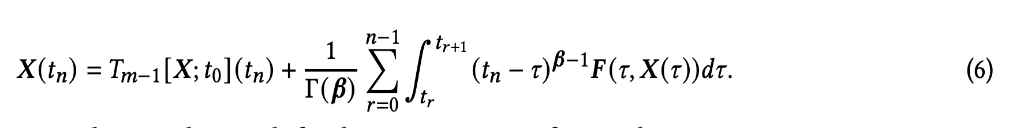

None
torch.Size([1, 128, 1024])


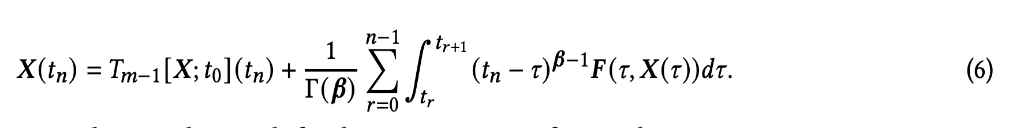

None

Predicted formula:
 <S> X ( t _ { n } ) = T _ { m - 1 } [ X ; t _ { 0 } ] ( t _ { n } ) + { \frac { 1 } { \Gamma ( \beta ) } } \sum _ { r = 0 } ^ { n - 1 } \int _ { t _ { r } } ^ { t r + 1 } ( t _ { n } - \tau ) ^ { \beta - 1 } F ( \tau , X ( \tau ) ) d \tau . \tag { 6 } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 270, 3)


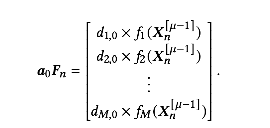

None
torch.Size([1, 128, 1024])


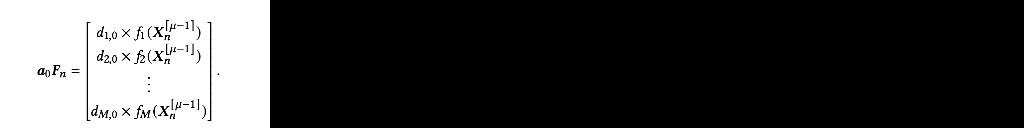

None

Predicted formula:
 <S> \begin{array} { c } { \omega _ { 1 } , x _ { 2 } = \left[ \begin{array} { c } { d _ { 1 } , \chi _ { 2 } \chi _ { 2 } ^ { ( y - 1 ) } } \\ { \omega _ { 1 } \times \beta _ { 2 } \chi _ { 3 } \chi _ { 3 } \chi _ { 3 } \chi _ { 3 } \chi _ { 3 } \chi _ { 3 } \chi _ { 3 } \chi _ { 3 } \chi _ { 3 } \chi _ { 4 } ^ { - 1 } \right] } \\ \end{array} \right] . <E> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 582, 3)


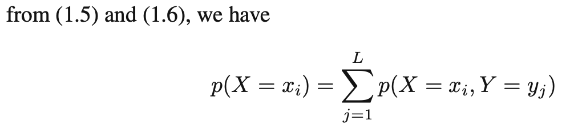

None
torch.Size([1, 128, 1024])


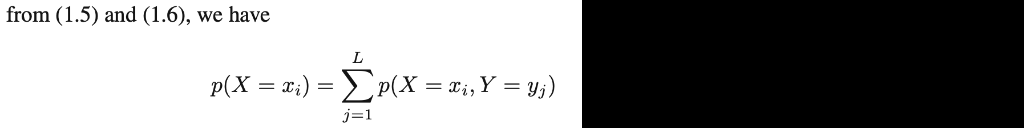

None

Predicted formula:
 <S> \begin{array} { l } { \mathrm { f r o m ~ ( 1 S ) ~ w ~ k a w e } } \\ { p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 768, 3)


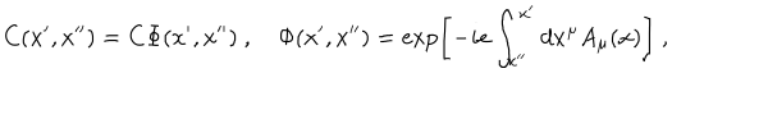

None
torch.Size([1, 128, 1024])


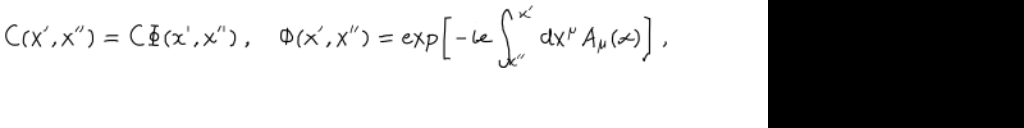

None

Predicted formula:
 <S> \begin{array} { c c } { { \subset } \chi ^ { \prime } { \star } ^ { \prime } ) = \subset { \mathbb G } ( { \Upsilon } ^ { * } { \cal A } ^ { \prime } ) \, , \quad { \mathbb O } ( { \cal N } ^ { \prime } { \star } ^ { \prime } ) = e { \times } P { \Big [ - { \omega } { \sum } ^ { * } { { \omega } } ^ { * } { { \omega } ^ { \mu } { \beta } _ { \mu } ( { \varphi } ) \Big ] \, . } \\ \end{array} <E> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 228, 3)


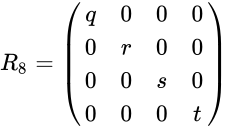

None
torch.Size([1, 128, 1024])


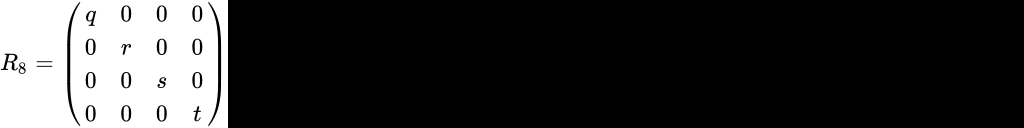

None

Predicted formula:
 <S> R _ { 8 } = \left( \begin{array} { c c c } { q } & { 0 } & { 0 } & { 0 } \\ { 0 } & { r } & { 0 } & { 0 } \\ { 0 } & { 0 } & { s } & { 0 } \\ { 0 } & { 0 } & { 0 } & { t } \\ \end{array} \right) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 1024, 3)


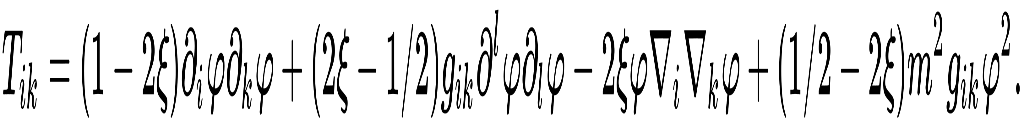

None
torch.Size([1, 128, 1024])


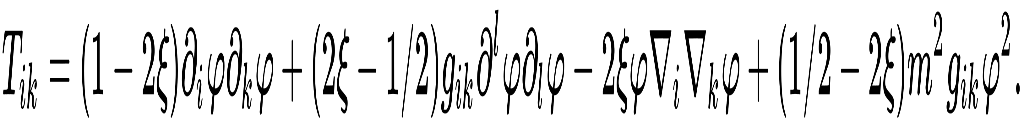

None

Predicted formula:
 <S> T _ { i k } = ( 1 - 2 \xi ) \partial _ { i } \varphi \partial _ { k } \varphi + ( 2 \xi - 1 / 2 ) g _ { i k } \partial ^ { l } \varphi \partial _ { l } \varphi - 2 \xi \varphi \nabla _ { i } \nabla _ { k } \varphi + ( 1 / 2 - 2 \xi ) m ^ { 2 } g _ { i k } \varphi ^ { 2 } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 727, 3)


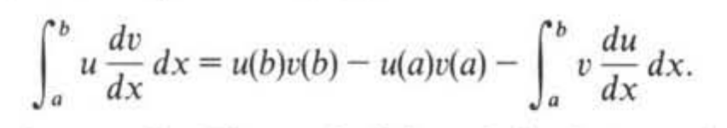

None
torch.Size([1, 128, 1024])


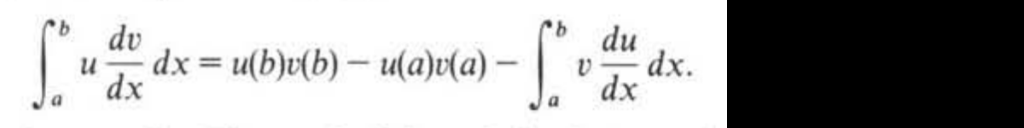

None

Predicted formula:
 <S> \int _ { a } ^ { b } u \frac { d v } { d \chi } \, d \chi = u ( b ) v ( b ) - u ( d ) v ( d ) - \int _ { a } ^ { b } v \, \frac { d u } { d \chi } \, d \chi . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 949, 3)


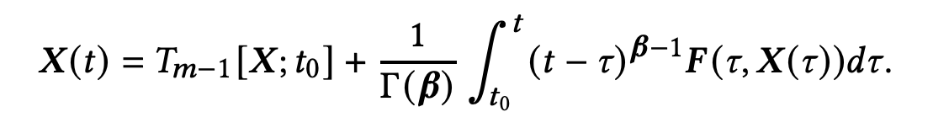

None
torch.Size([1, 128, 1024])


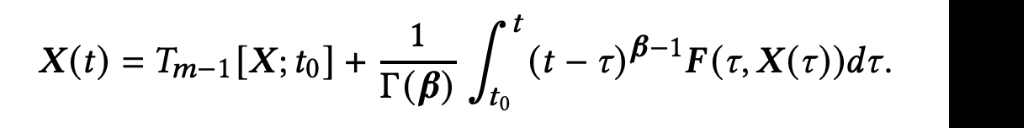

None

Predicted formula:
 <S> X ( t ) = T _ { m - 1 } [ X ; t _ { 0 } ] + \frac { 1 } { \Gamma ( \beta ) } \int _ { t _ { 0 } } ^ { t } ( t - \tau ) ^ { \beta - 1 } F ( \tau , X ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 270, 3)


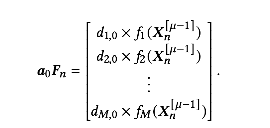

None
torch.Size([1, 128, 1024])


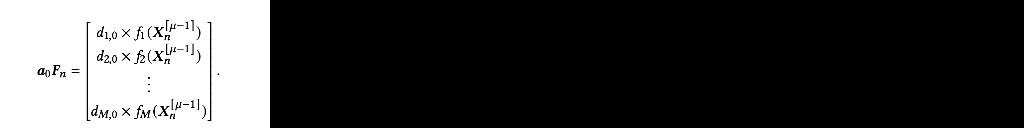

None

Predicted formula:
 <S> \begin{array} { c } { \omega _ { 1 } , x _ { 2 } = \left[ \begin{array} { c } { d _ { 1 } , \chi _ { 2 } \chi _ { 2 } ^ { ( y - 1 ) } } \\ { \omega _ { 1 } \times \beta _ { 2 } \chi _ { 3 } \chi _ { 3 } \chi _ { 3 } \chi _ { 3 } \chi _ { 3 } \chi _ { 3 } \chi _ { 3 } \chi _ { 3 } \chi _ { 3 } \chi _ { 4 } ^ { - 1 } \right] } \\ \end{array} \right] . <E> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 768, 3)


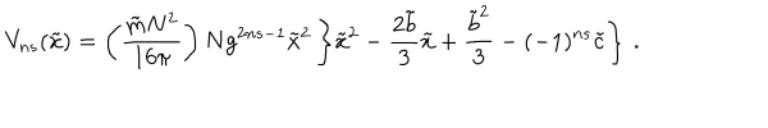

None
torch.Size([1, 128, 1024])


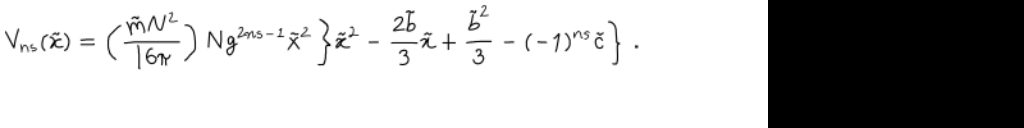

None

Predicted formula:
 <S> \chi _ { r s } ( { \cal E } ) = \left( \frac { \gamma \delta ^ { 2 } } { | \xi _ { N } } \right) N _ { 2 } ^ { 2 \gamma s - 1 } { \tilde { \lambda } } ^ { 2 \gamma s - 1 } { \tilde { \lambda } } ^ { 2 } { \dot { s } } + \frac { { { \tilde { z } } ^ { 2 } } { 2 } - \left( - \eta \right) ^ { \gamma \circ s } { \tilde { \xi } } } \right) \, . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 768, 3)


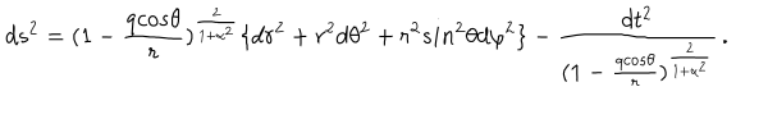

None
torch.Size([1, 128, 1024])


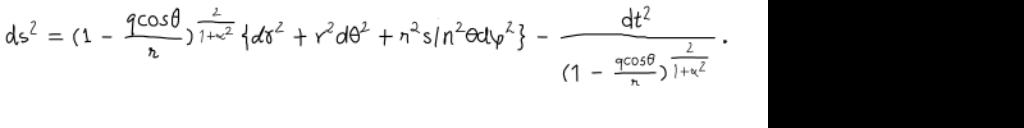

None

Predicted formula:
 <S> \begin{array} { c } { d z ^ { 2 } = \langle 1 \, - \, { \frac { 7 \mathrm { e c s } s } { n } } \, { \frac { z } { 2 } } \, \rangle \, \langle d \zeta ^ { 2 } \, + \, { \gamma ^ { 2 } } \, { \cal d } ^ { 2 } \, + \, { \gamma ^ { 2 } } \, { \cal d } ^ { 2 } \, + \, { \gamma ^ { 2 } } \, { \cal d } ^ { 2 } \, { \cal d } ^ { 2 } \, + \, { \frac { 8 } { 1


<IPython.core.display.Math object>

None
(128, 582, 3)


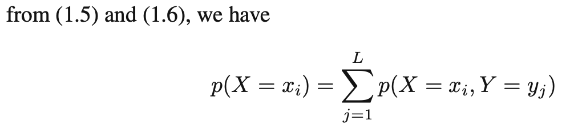

None
torch.Size([1, 128, 1024])


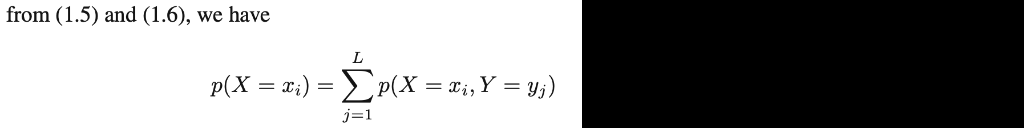

None

Predicted formula:
 <S> \begin{array} { l } { \mathrm { f r o m ~ ( 1 S ) ~ w ~ k a w e } } \\ { p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 1024, 3)


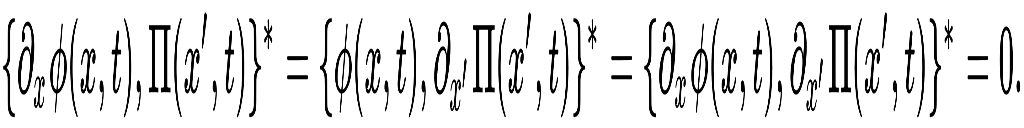

None
torch.Size([1, 128, 1024])


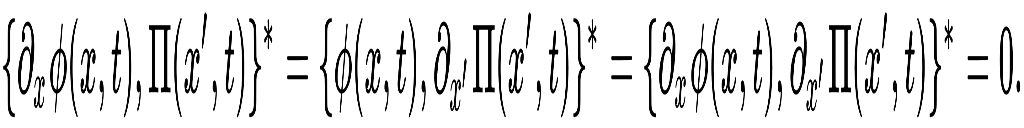

None

Predicted formula:
 <S> \{ \partial _ { x } \phi ( x , t ) , \Pi ( x ^ { \prime } , t ) \} ^ { * } = \{ \phi ( x , t ) , \partial _ { x ^ { \prime } } \Pi ( x ^ { \prime } , t ) \} ^ { * } = \{ \partial _ { x } \phi ( x , t ) , \partial _ { x ^ { \prime } } \Pi ( x ^ { \prime } , t ) \} ^ { * } = 0 . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 1024, 3)


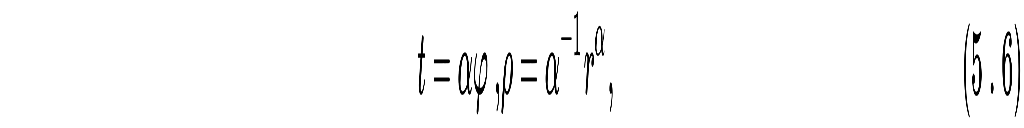

None
torch.Size([1, 128, 1024])


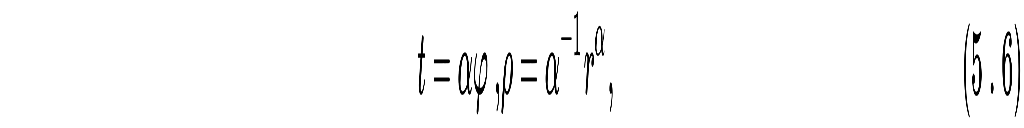

None

Predicted formula:
 <S> t = \alpha \varphi \, , \rho = \alpha ^ { - 1 } r ^ { \alpha } , \tag { 5 . 6 } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 1024, 3)


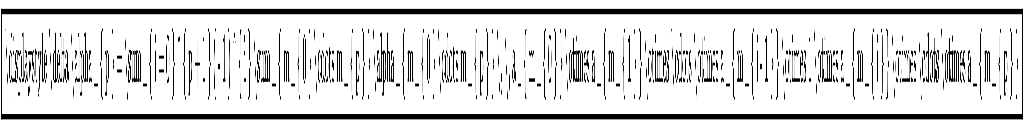

None
torch.Size([1, 128, 1024])


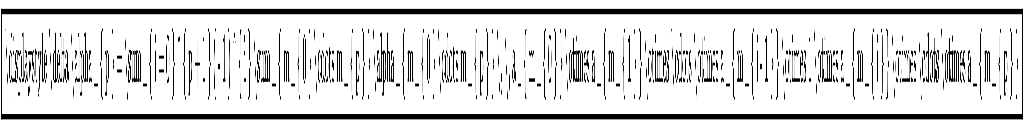

None

Predicted formula:
 <S> \fbox { \displaystyle { { \partial } _ { i } = 0 } \\ { \displaystyle { \partial } _ { i } = 0 } \\ { \displaystyle { \partial } _ { i } = 0 } \\ { \displaystyle { \partial } _ { i } } } \, { \partial } _ { i } = 0 . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [18]:
for image in IMAGES:
    predict(image)

(41, 178, 3)


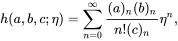

None
torch.Size([3, 41, 178])

Predicted formula:
 <S> a _ { a , b , c , b , c , p = \sum \frac { 1 } { 2 } \left\{ \frac { ( a , b , c , p , p = \sum \frac { 1 } { 2 } \left\{ \frac { ( a , b , c , p , p = \sum \frac { 1 } { 2 } \left\{ \frac { ( a , b , c , p , p = \sum \frac { 1 } { 2 } \left\{ \frac { a ( b , b , c , p , p , p = \sum \frac { 1 } { 2 } \right\} \frac { 1 ( b , b , c , p , p ,


<IPython.core.display.Math object>

None
(116, 516, 3)


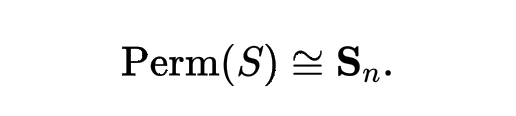

None
torch.Size([3, 116, 516])

Predicted formula:
 <S> \mathrm { P e r m } ( S ) \cong { \bf S } _ { n } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(112, 424, 3)


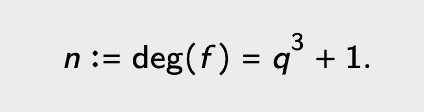

None
torch.Size([3, 112, 424])

Predicted formula:
 <S> n : = \, \mathrm { d e g } ( \, f \, ) \, = \, q ^ { 3 } + 1 . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(152, 658, 3)


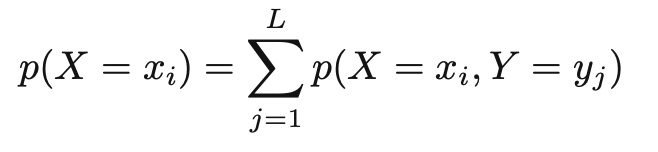

None
torch.Size([3, 152, 658])

Predicted formula:
 <S> p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(320, 1080, 3)


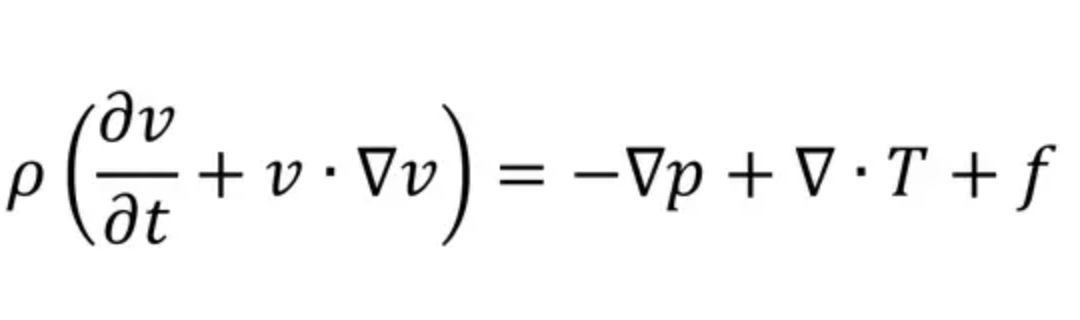

None
torch.Size([3, 320, 1080])

Predicted formula:
 <S> \begin{array} { c c c } { { } & { } \\ { { } & { { } } \\ \end{array} { } _ { { } } } & { { } & { { } } \\ { { } _ { { } } } { } & { { } } } & { { } \\ \end{array} { } } } & { { } ~ { } ~ { } ~ { } ~ { } ~ { } ~ { } ~ { } ~ { } ~ { } ~ { } ~ { } ~ { } ~ { } ~ { } ~ { } ~ { } ~ { } ~ { } \\ \end{array} <E>


<IPython.core.display.Math object>

None
(200, 1424, 3)


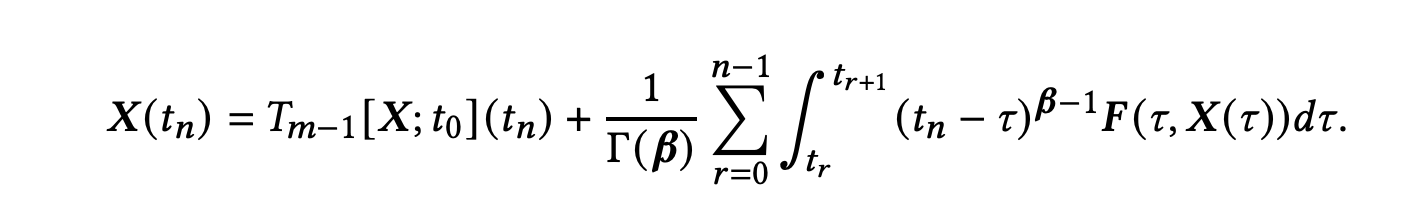

None
torch.Size([3, 200, 1424])

Predicted formula:
 <S> X ( t _ { n } ) = T _ { m - 1 } [ X ; t _ { 0 } ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \beta ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { t _ { r } } ^ { t _ { r + 1 } } ( t _ { n } - \tau ) ^ { \beta - 1 } \int _ { t _ { r } } ^ { t _ { r + 1 } } ( t _ { n } - \tau ) ^ { \beta - 1 } <E> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(188, 1950, 3)


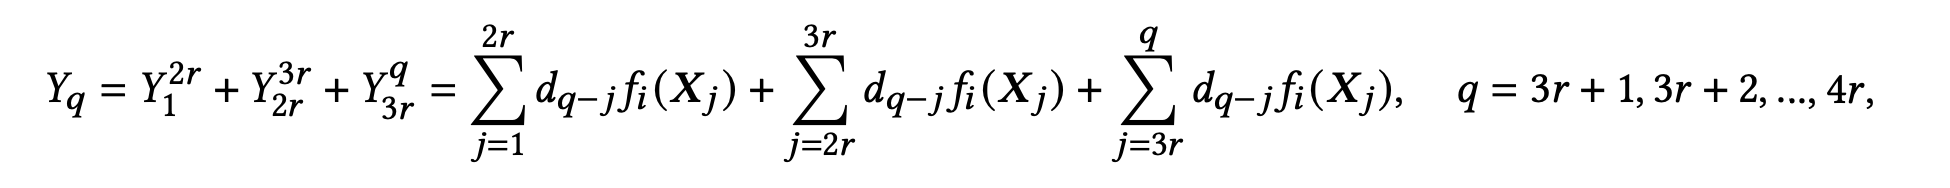

None
torch.Size([3, 188, 1950])

Predicted formula:
 <S> Y _ { q } = Y _ { 1 } ^ { 2 r } + Y _ { 2 r } ^ { 3 r } + Y _ { 3 r } ^ { q } = \sum _ { j = 1 } ^ { 2 r } d _ { q - j f _ { i } ( X _ { j } ) + \sum _ { j = 2 r } ^ { 3 r } d _ { q - j f _ { i } ( X _ { j } ) + \sum _ { j = 2 r } ^ { 3 r } d _ { q - j } f _ { i } (


<IPython.core.display.Math object>

None
(202, 1774, 3)


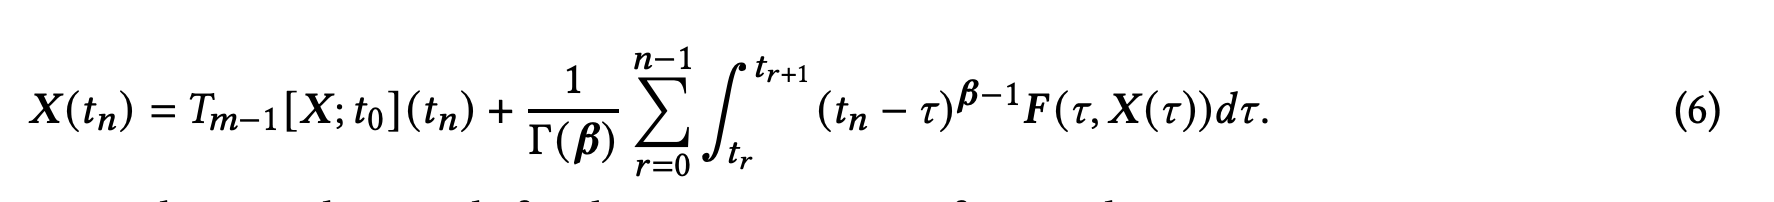

None
torch.Size([3, 202, 1774])

Predicted formula:
 <S> \begin{array} { l l l } { X ( t _ { n } ) = T _ { m - 1 } [ X ; t _ { 0 } ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \beta ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { f _ { r } } ^ { t _ { r + 1 } } ( t _ { n } - \tau ) ^ { \beta - 1 } F ( \tau _ { n } - \tau ) ^ { \beta - 1 } F ( \tau _ { n } - \tau ) ^ { \beta - 1 }


<IPython.core.display.Math object>

None
(384, 812, 3)


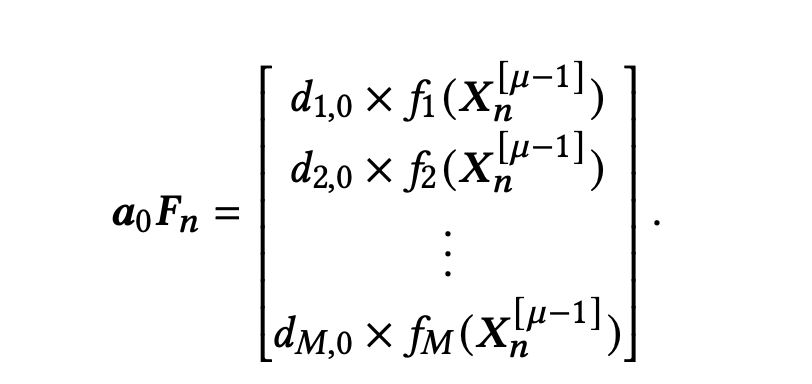

None
torch.Size([3, 384, 812])

Predicted formula:
 <S> \begin{array} { c c } { d _ { 1 , 0 } { f _ { 1 , 0 } \times f _ { 1 } ( X _ { n } ^ { [ \mu - 1 ] } ) } \\ \end{array} } \\ \end{array} \begin{array} { c c } { { } & { } \\ { { } & { { } _ { 1 , 0 } \times f _ { 2 } ( X _ { n } ^ { [ \mu - 1 ] } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(224, 1020, 3)


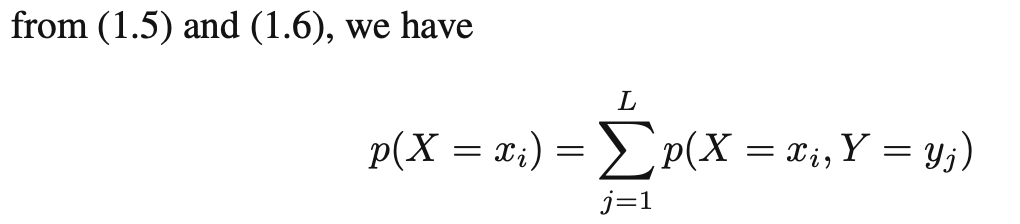

None
torch.Size([3, 224, 1020])

Predicted formula:
 <S> \mathrm { f o m } \left( 1 . S \right) \mathrm { ~ a n d ~ } \left( 1 . 6 \right) , \mathrm { ~ w e ~ h u v e } \qquad \qquad \qquad \qquad j = 1 } ^ { L } p \left( X = x _ { i } , Y = y _ { j } \right) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(100, 600, 3)


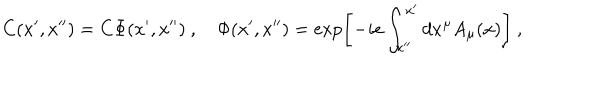

None
torch.Size([3, 100, 600])

Predicted formula:
 <S> \begin{array} { l l } { C ( \zeta \times \kappa ^ { \prime } ) = \subset \varepsilon \Phi ( \infty ^ { \prime } , \beta ^ { \prime } ) = \varepsilon < \varepsilon \gamma \left[ - \omega \sum _ { s } ^ { \varphi } \omega ^ { \prime } , } & { \underbrace { \otimes \varepsilon \gamma \left[ - \omega \sum _ { s } ^ { \varphi } \omega ^ { \prime } , } & { 0 } \\ { - \varepsilon < - \varepsilon < - s - \pi < - s - s - s - \infty < - s + \infty < - s < - \infty < - s + s + s - s -


<IPython.core.display.Math object>

None
(128, 228, 3)


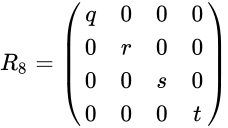

None
torch.Size([3, 128, 228])

Predicted formula:
 <S> R _ { 8 } = \left( \begin{array} { c c c c c c c c c c } { q } & { 0 } & { 0 } & { 0 } \\ { 0 } & { r } & { 0 } & { 0 } \\ { 0 } & { r } & { 0 } & { 0 } \\ { 0 } & { 0 } & { s } & { 0 } \\ { 0 } & { 0 } & { 0 } & { t } \\ \end{array} \right) \Biggl ( \begin{array} { c c c c c c c c c c } { q } & { 0 } & { 0 } &


<IPython.core.display.Math object>

None
(128, 3260, 3)


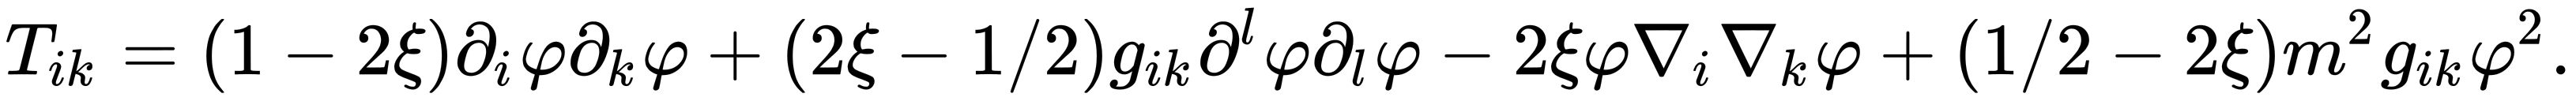

None
torch.Size([3, 128, 3260])

Predicted formula:
 <S> T _ { i k } = ( 1 - 2 \xi ) \partial _ { i } \varphi \partial _ { k } \varphi + ( 2 \xi + ( 2 \xi + ( 2 \xi + ( 2 \xi ) + ( 2 \xi ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(150, 852, 3)


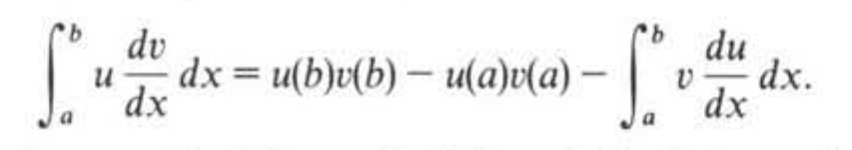

None
torch.Size([3, 150, 852])

Predicted formula:
 <S> \int _ { a } ^ { b } u \, \frac { d v } { d \chi } \, d \chi = u ( b ) \psi ( \vec { b } ) - u ( d ) v ( \vec { d } ) - \int _ { a } ^ { b } \, v \, \frac { d u } { d \chi } \, d \chi _ { c } = \, , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(152, 1128, 3)


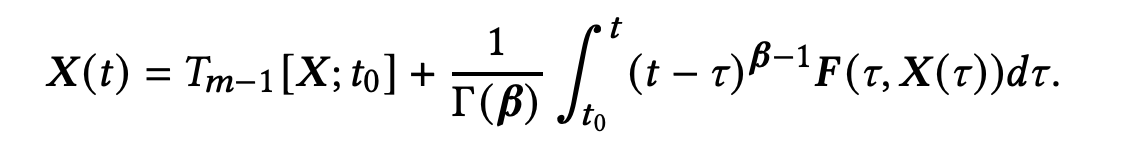

None
torch.Size([3, 152, 1128])

Predicted formula:
 <S> X ( t ) = T _ { m - 1 } [ X ; t _ { 0 } ] + \frac { 1 } { \Gamma ( \beta ) } \int _ { t _ { 0 } } ^ { t } ( t - \tau ) ^ { \beta - 1 } F ( \tau , X ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(384, 812, 3)


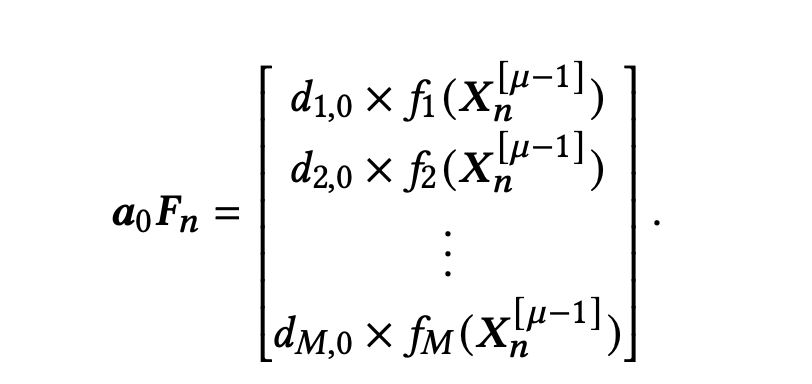

None
torch.Size([3, 384, 812])

Predicted formula:
 <S> \begin{array} { c c } { d _ { 1 , 0 } { f _ { 1 , 0 } \times f _ { 1 } ( X _ { n } ^ { [ \mu - 1 ] } ) } \\ \end{array} } \\ \end{array} \begin{array} { c c } { { } & { } \\ { { } & { { } _ { 1 , 0 } \times f _ { 2 } ( X _ { n } ^ { [ \mu - 1 ] } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(100, 600, 3)


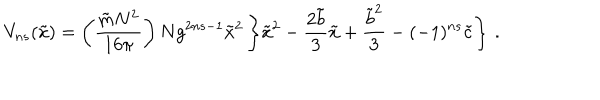

None
torch.Size([3, 100, 600])

Predicted formula:
 <S> \begin{array} { c c } { \chi _ { n , } ( { \cal E } ) = ( \frac { \gamma \lambda ^ { 2 } } { l } ) \, N _ { n , s } ( { \cal E } ) = ( \frac { \gamma \lambda ^ { 2 } } { l \xi } ) \, N _ { n s + s } = ( \frac { \gamma \lambda ^ { 2 } } { l \xi } ) \, N _ { n s + s } = ( - \gamma - s + s - r - s + s - r - s + s - r - s + s - r - s + s


<IPython.core.display.Math object>

None
(100, 600, 3)


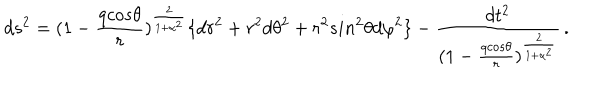

None
torch.Size([3, 100, 600])

Predicted formula:
 <S> \begin{array} { c c } { \mathrm { d e x } = ( 1 - \frac { S G S } { 2 } ) + \frac { z } { 2 } } \left\{ \zeta d ^ { 2 } + r ^ { 2 } \phi ( s ^ { 2 } + r ^ { 2 } s ( r ^ { 2 } ) + r ^ { 2 } s ( r ^ { 2 } + r ^ { 2 } s ( r ^ { 2 } ) + r ^ { 2 } s ( r ^ { 2 } \otimes s ) ^ { 2 } } \\ { - s - r - s - r - r


<IPython.core.display.Math object>

None
(224, 1020, 3)


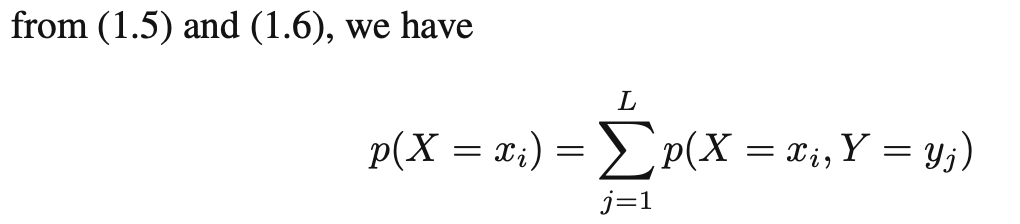

None
torch.Size([3, 224, 1020])

Predicted formula:
 <S> \mathrm { f o m } \left( 1 . S \right) \mathrm { ~ a n d ~ } \left( 1 . 6 \right) , \mathrm { ~ w e ~ h u v e } \qquad \qquad \qquad \qquad j = 1 } ^ { L } p \left( X = x _ { i } , Y = y _ { j } \right) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 3264, 3)


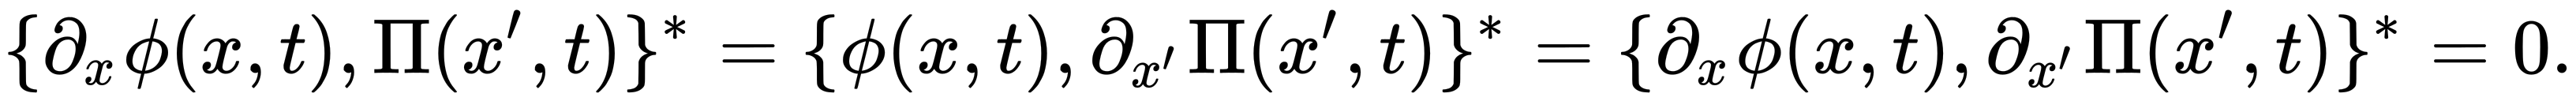

None
torch.Size([3, 128, 3264])

Predicted formula:
 <S> \{ \partial _ { x } \phi ( x , t ) , \Pi ( x ^ { \prime } , t ) \} ^ { * } = \{ \phi ( x ^ { \prime } , t ) \} ^ { * } = \{ \phi ( x ^ { \prime } , t ) \} ^ { * } = \{ \phi <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 4042, 3)


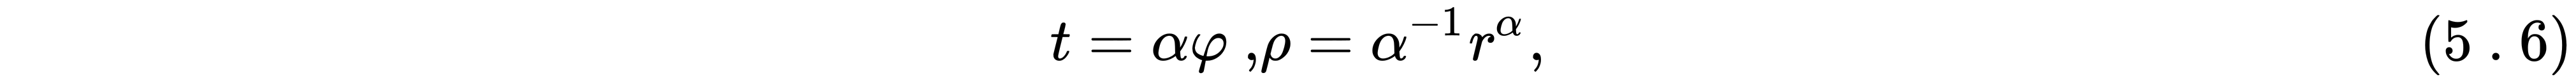

None
torch.Size([3, 128, 4042])

Predicted formula:
 <S> t = \alpha \varphi \, \, , \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \,


<IPython.core.display.Math object>

None
(128, 9794, 3)


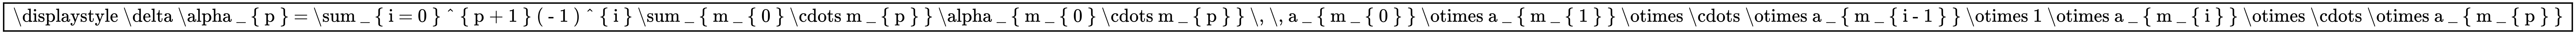

None
torch.Size([3, 128, 9794])

Predicted formula:
 <S> \fbox { \displaystyle { \displaystyle { \sum _ { d e l t a ~ ~ } ( e l t a ~ ~ ~ } _ { a l p h a } - \{ \mathrm { p h a } _ { - 4 } } } } } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [11]:
for image in IMAGES:
    predict_simple(image)

(128, 556, 3)


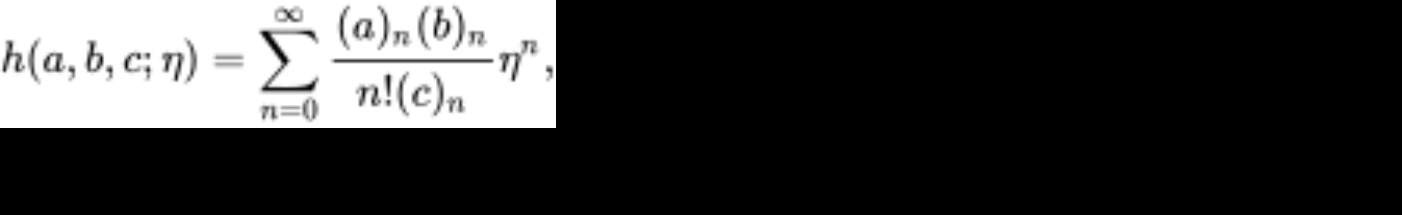

None
torch.Size([1, 215, 1402])

Predicted formula:
 <S> \begin{array} { c c } { h \{ a , b , c ; \eta \} = \sum _ { r = 1 , l } ^ { \infty } \frac { ( a ) _ { n } ( b ) _ { r _ { n } } } { n ! ( c ) _ { n _ { n } } } \eta ^ { r } , } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 569, 3)


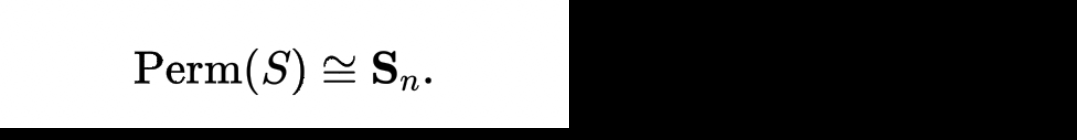

None
torch.Size([1, 140, 1077])

Predicted formula:
 <S> \begin{array} { c } { \mathrm { P e r m } ( S ) \cong { \bf S } _ { n } . } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 485, 3)


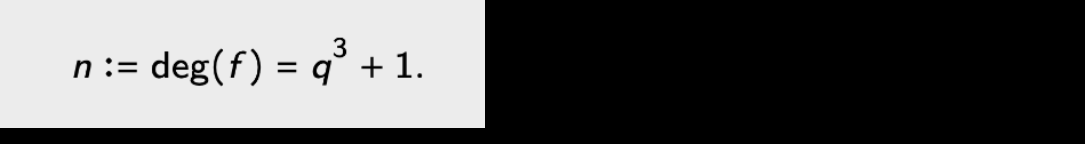

None
torch.Size([1, 144, 1085])

Predicted formula:
 <S> \begin{array} { c } { n : = \, \mathrm { d e g } ( f ) \, = \, { q ^ { 3 } } + 1 . } \\ { } \\ { m } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 554, 3)


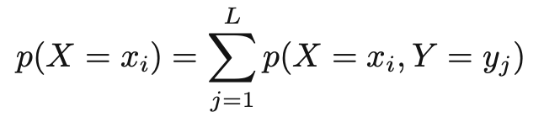

None
torch.Size([1, 128, 554])

Predicted formula:
 <S> p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) \quad , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 432, 3)


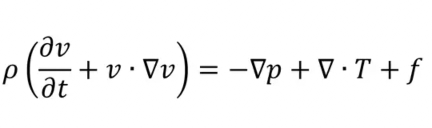

None
torch.Size([1, 128, 432])

Predicted formula:
 <S> \rho \left( \frac { \partial v } { \partial t } + \nu \cdot \nabla \nu \right) = - \nabla p + \nabla \cdot T + f \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \rho \left( \frac { \partial v } { \partial t } + \nu \cdot T + f \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \rho \left( \frac { \partial v } { \partial t } + \nu \cdot \nabla \nu \right) = - \nabla p + C \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \rho \left( \frac { \partial v } { \partial v


<IPython.core.display.Math object>

None
(128, 911, 3)


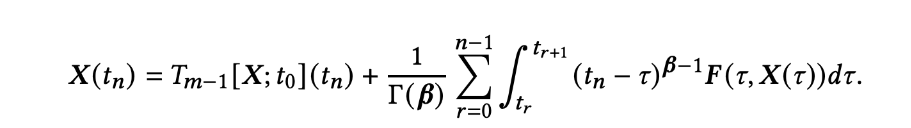

None
torch.Size([1, 128, 911])

Predicted formula:
 <S> X ( t _ { n } ) = T _ { m - 1 } [ X ; t _ { 0 } ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \beta ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { t _ { r } } ^ { t _ { r + 1 } } ( t _ { n } - \tau ) ^ { \beta - 1 } F ( \tau , X ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 1328, 3)


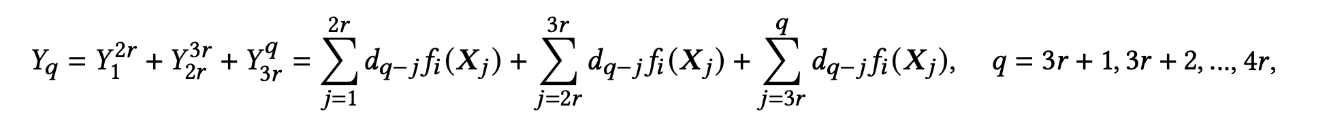

None
torch.Size([1, 128, 1328])

Predicted formula:
 <S> Y _ { q } = \, Y _ { 1 } ^ { 2 r } + Y _ { 2 r } ^ { 9 r } + Y _ { 3 r } ^ { q } = \sum _ { j = 1 } ^ { 2 r } d _ { q - j f _ { i } } ( X _ { j } ) + \sum _ { j = 2 r } ^ { 3 r } d _ { q - j f _ { i } ( X _ { j } ) + \sum _ { j = 3 r } ^ { q } d _ { q - j f _ { i } (


<IPython.core.display.Math object>

None
(128, 1124, 3)


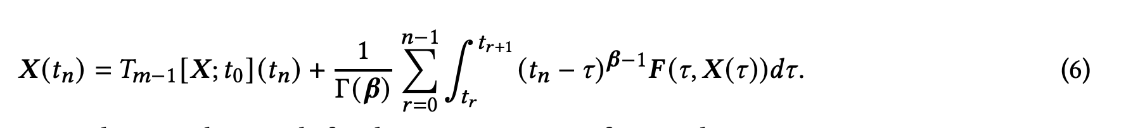

None
torch.Size([1, 128, 1124])

Predicted formula:
 <S> X ( t _ { n } ) = T _ { m - 1 } [ X ; t _ { 0 } ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \beta ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { t _ { r } } ^ { t _ { r + 1 } } ( t _ { n } - \tau ) ^ { \beta - 1 } F ( \tau , X ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 271, 3)


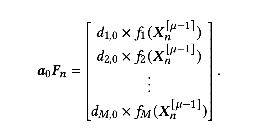

None
torch.Size([1, 128, 271])

Predicted formula:
 <S> \begin{array} { c } { \omega _ { \alpha } , x _ { \alpha } = \left[ \begin{array} { c } { d _ { \alpha } \chi \, s \, s \, s ( y ^ { \mu - 1 } ) } \\ { \omega _ { \alpha } \chi \, s \, s \, s ( y ^ { \mu - 1 } ) } \\ { \omega _ { \alpha } \chi \, s \, s \, s } \\ { \omega _ { \alpha } \chi \, s \, s _ { \beta } ( x ^ { \mu - 1 } ) } \\ { \omega _ { \alpha } \chi \, s \, s } \\ \end{array} \right] . <E> <P>


<IPython.core.display.Math object>

None
(128, 583, 3)


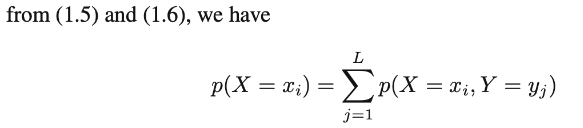

None
torch.Size([1, 128, 583])

Predicted formula:
 <S> \begin{array} { l l l } { \mathrm { f r o m ~ ( 1 S ) ~ w ~ a v e ~ h a v e } } \\ { p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) } & { } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 768, 3)


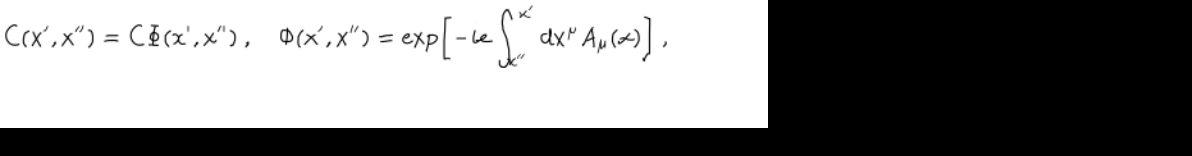

None
torch.Size([1, 156, 1192])

Predicted formula:
 <S> \begin{array} { c c } { \subset { \cal G } ( { \bf X } ^ { \prime } , { \cal S } ^ { \prime } ) , } & { \mathrm { ~ Q } ( { \cal N } ^ { \prime } , { \cal X } ^ { \prime } ) = e \times { \cal P } \left[ - { \bf \omega } \sum _ { { \cal X } ^ { \prime } } ^ { * } { \bf A } ^ { \mu } { \cal A } _ { \mu } ( \varphi ) \right] . } \\ { } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 228, 3)


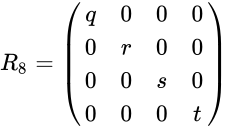

None
torch.Size([1, 128, 228])

Predicted formula:
 <S> R _ { 8 } = \left( \begin{array} { c c c c c c c c c c } { q } & { 0 } & { 0 } & { 0 } \\ { 0 } & { r } & { 0 } & { 0 } \\ { 0 } & { r } & { 0 } & { 0 } \\ { 0 } & { 0 } & { s } & { 0 } \\ { 0 } & { 0 } & { 0 } & { t } \\ \end{array} \right) \Biggl ( \begin{array} { c c c c c c c c c c } { q } & { 0 } & { 0 } &


<IPython.core.display.Math object>

None
(128, 3260, 3)


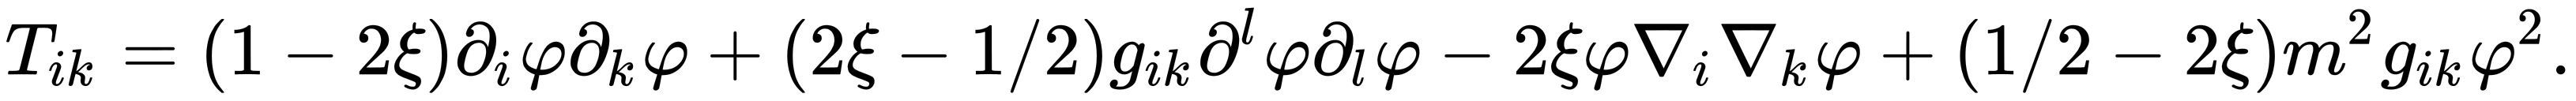

None
torch.Size([1, 128, 3260])

Predicted formula:
 <S> T _ { i k } = ( 1 - 2 \xi ) \partial _ { i } \varphi \partial _ { k } \varphi + ( 2 \xi + ( 2 \xi + ( 2 \xi + ( 2 \xi ) + ( 2 \xi ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 727, 3)


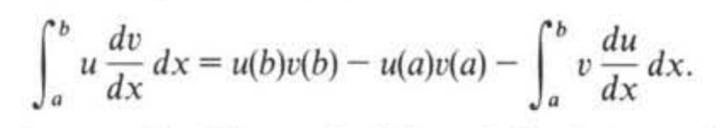

None
torch.Size([1, 128, 727])

Predicted formula:
 <S> \int _ { a } ^ { b } u \frac { d v } { d \chi } \, d \chi = u ( b ) v ( b ) - u ( d ) v ( d ) - \int _ { a } ^ { b } v \, \frac { d u } { d \chi } \, d \chi . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 950, 3)


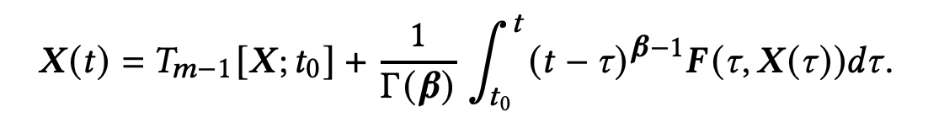

None
torch.Size([1, 128, 950])

Predicted formula:
 <S> X ( t ) = T _ { m - 1 } [ X ; t _ { 0 } ] + \frac { 1 } { \Gamma ( \beta ) } \int _ { t _ { 0 } } ^ { t } ( t - \tau ) ^ { \beta - 1 } F ( \tau , X ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 271, 3)


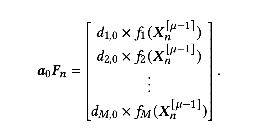

None
torch.Size([1, 128, 271])

Predicted formula:
 <S> \begin{array} { c } { \omega _ { \alpha } , x _ { \alpha } = \left[ \begin{array} { c } { d _ { \alpha } \chi \, s \, s \, s ( y ^ { \mu - 1 } ) } \\ { \omega _ { \alpha } \chi \, s \, s \, s ( y ^ { \mu - 1 } ) } \\ { \omega _ { \alpha } \chi \, s \, s \, s } \\ { \omega _ { \alpha } \chi \, s \, s _ { \beta } ( x ^ { \mu - 1 } ) } \\ { \omega _ { \alpha } \chi \, s \, s } \\ \end{array} \right] . <E> <P>


<IPython.core.display.Math object>

None
(128, 768, 3)


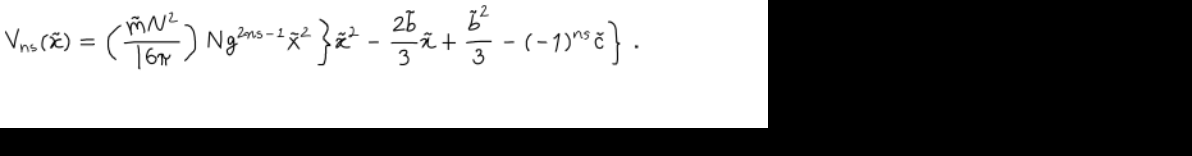

None
torch.Size([1, 156, 1192])

Predicted formula:
 <S> { \cal V } _ { \mathrm { r e s } } { \cal Z } = < \frac { \tilde { \gamma } N ^ { 2 } } { | \xi _ { N } } > { \cal M } ^ { 2 \gamma s - 1 } \tilde { \lambda } ^ { 2 } - \frac { z } { 2 } \tilde { \lambda } + \frac { \tilde { z } ^ { 2 } } { 2 } - ( - \eta ) ^ { \gamma \circ s } { \bf e } } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 768, 3)


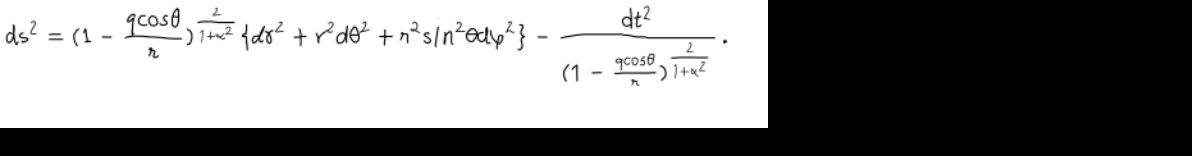

None
torch.Size([1, 156, 1192])

Predicted formula:
 <S> \begin{array} { c } { d z ^ { 2 } = \langle 1 - \frac { z \mathrm { e c s } } { k } ) ^ { \frac { z } { + z ^ { 2 } } } \langle d \zeta ^ { 2 } + r ^ { 2 } { s } / \kappa ^ { 2 } } + r ^ { 2 } { s } / \kappa ^ { 2 } } { s } | \kappa ^ { 2 } } & { - } & { { \mathrm { e s t } s g ^ { 2 } } \\ { \pi } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 583, 3)


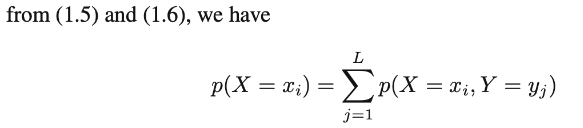

None
torch.Size([1, 128, 583])

Predicted formula:
 <S> \begin{array} { l l l } { \mathrm { f r o m ~ ( 1 S ) ~ w ~ a v e ~ h a v e } } \\ { p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) } & { } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 3264, 3)


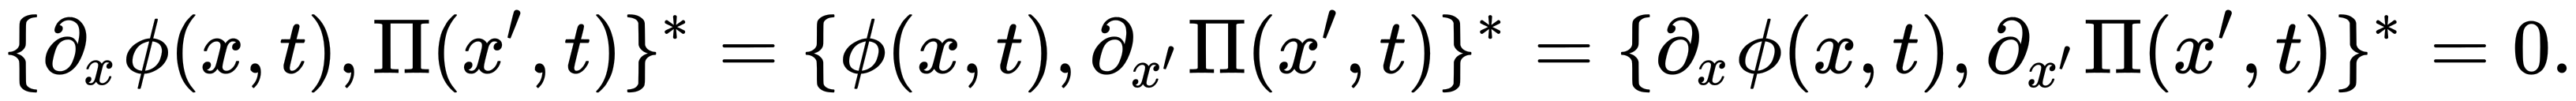

None
torch.Size([1, 128, 3264])

Predicted formula:
 <S> \{ \partial _ { x } \phi ( x , t ) , \Pi ( x ^ { \prime } , t ) \} ^ { * } = \{ \phi ( x ^ { \prime } , t ) \} ^ { * } = \{ \phi ( x ^ { \prime } , t ) \} ^ { * } = \{ \phi <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 4042, 3)


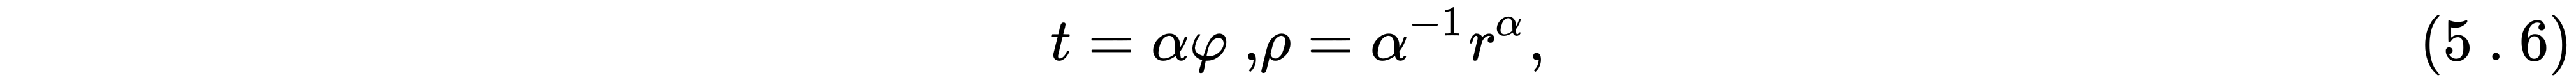

None
torch.Size([1, 128, 4042])

Predicted formula:
 <S> t = \alpha \varphi \, \, , \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \,


<IPython.core.display.Math object>

None
(128, 9794, 3)


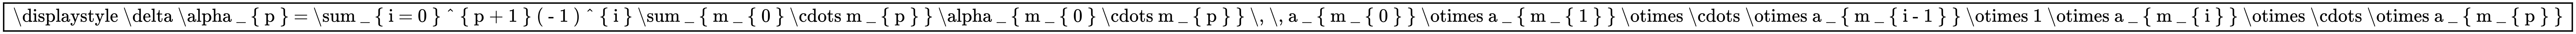

None
torch.Size([1, 128, 9794])

Predicted formula:
 <S> \fbox { \displaystyle { \displaystyle { \sum _ { d e l t a ~ ~ } ( e l t a ~ ~ ~ } _ { a l p h a } - \{ \mathrm { p h a } _ { - 4 } } } } } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [19]:
for image in IMAGES:
    predict_scaled(image)